## SF crime data analysis and modeling with Spark

In [2]:
from csv import reader
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from ggplot import *
from folium import plugins
import warnings
import os
import itertools

In [3]:
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import to_date, unix_timestamp, year, month, hour, to_timestamp
from pyspark.sql.functions import concat, col, lit
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Load crime data from January 2003 to May 2018
df_crime = spark.read.format("csv").option("header", "true").load("/FileStore/tables/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
df_crime.createOrReplaceTempView("sf_crime")

In [6]:
df_crime.printSchema()

root
-- IncidntNum: string (nullable = true)
-- Category: string (nullable = true)
-- Descript: string (nullable = true)
-- DayOfWeek: string (nullable = true)
-- Date: string (nullable = true)
-- Time: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- Resolution: string (nullable = true)
-- Address: string (nullable = true)
-- X: string (nullable = true)
-- Y: string (nullable = true)
-- Location: string (nullable = true)
-- PdId: string (nullable = true)

In [7]:
# Data size
df_crime.count()

Out[ 30 ]: 2215024

In [8]:
# Data processing
df_crime = df_crime.filter(df_crime['category'] != 'NON-CRIMINAL').na.drop()
df_crime = (df_crime
            .withColumn('X',df_crime['X'].cast('float'))
            .withColumn('Y',df_crime['Y'].cast('float'))
            .filter(df_crime['X'] < 122)
            .filter(df_crime['Y'] < 37.82))

In [9]:
# Create a columns with datetime formats
df_crime = (df_crime
            .withColumn('Datetime', concat(col("Date"), lit(" "), col("Time")))
            .withColumn("Datetime", unix_timestamp("Datetime", "MM/dd/yyyy HH:mm").cast('timestamp'))
            .withColumn("Year", year(col("Datetime")))
            .withColumn("Month", month(col("Datetime"))).withColumn("hour", hour(col("Datetime"))))

df_crime.show(5)

+----------+---------------+--------------------+---------+----------+-----+----------+----------+--------------------+-----------+---------+--------------------+--------------+-------------------+----+-----+----+
IncidntNum| Category| Descript|DayOfWeek| Date| Time|PdDistrict|Resolution| Address| X| Y| Location| PdId| Datetime|Year|Month|hour|
+----------+---------------+--------------------+---------+----------+-----+----------+----------+--------------------+-----------+---------+--------------------+--------------+-------------------+----+-----+----+
 150098210| ROBBERY|ROBBERY, BODILY F...| Sunday|02/01/2015|15:45|TENDERLOIN| NONE|300 Block of LEAV...|-122.414406| 37.78419|(37.7841907151119...|15009821003074|2015-02-01 15:45:00|2015| 2| 15|
 150098210| ASSAULT|AGGRAVATED ASSAUL...| Sunday|02/01/2015|15:45|TENDERLOIN| NONE|300 Block of LEAV...|-122.414406| 37.78419|(37.7841907151119...|15009821004014|2015-02-01 15:45:00|2015| 2| 15|
 150098210|SECONDARY CODES| DOMESTIC VIOLENCE| Sunday|02/01/2015|15:45|TENDERLOIN| NONE|300 Block of LEAV...|-122.414406| 37.78419|(37.7841907151119...|15009821015200|2015-02-01 15:45:00|2015| 2| 15|
 150098226| VANDALISM|MALICIOUS MISCHIE...| Tuesday|01/27/2015|19:00| NORTHERN| NONE|LOMBARD ST / LAGU...| -122.43112| 37.80047|(37.8004687042875...|15009822628160|2015-01-27 19:00:00|2015| 1| 19|
 150098248|SECONDARY CODES| DOMESTIC VIOLENCE| Saturday|01/31/2015|21:00| BAYVIEW| NONE|700 Block of KIRK...|-122.374016|37.729202|(37.729203356539,...|15009824815200|2015-01-31 21:00:00|2015| 1| 21|
+----------+---------------+--------------------+---------+----------+-----+----------+----------+--------------------+-----------+---------+--------------------+--------------+-------------------+----+-----+----+
only showing top 5 rows

#### OLAP: 
##### 1. The number of crimes for different category.

In [11]:
q1_result = df_crime.groupBy('category').count().orderBy('count', ascending=False)
q1_result.show()

+--------------------+------+
 category| count|
+--------------------+------+
 LARCENY/THEFT|480418|
 OTHER OFFENSES|309319|
 ASSAULT|194685|
 VEHICLE THEFT|126587|
 DRUG/NARCOTIC|119621|
 VANDALISM|116058|
 WARRANTS|101365|
 BURGLARY| 91542|
 SUSPICIOUS OCC| 80441|
 MISSING PERSON| 64961|
 ROBBERY| 55864|
 FRAUD| 41540|
 SECONDARY CODES| 25830|
FORGERY/COUNTERFE...| 23050|
 WEAPON LAWS| 22233|
 TRESPASS| 19447|
 PROSTITUTION| 16699|
 STOLEN PROPERTY| 11889|
SEX OFFENSES, FOR...| 11741|
 DISORDERLY CONDUCT| 10038|
+--------------------+------+
only showing top 20 rows

In [12]:
# Show the number of crimes for different category
q1 = q1_result.toPandas()
print (q1)

category count
0 LARCENY/THEFT 480418
1 OTHER OFFENSES 309319
2 ASSAULT 194685
3 VEHICLE THEFT 126587
4 DRUG/NARCOTIC 119621
5 VANDALISM 116058
6 WARRANTS 101365
7 BURGLARY 91542
8 SUSPICIOUS OCC 80441
9 MISSING PERSON 64961
10 ROBBERY 55864
11 FRAUD 41540
12 SECONDARY CODES 25830
13 FORGERY/COUNTERFEITING 23050
14 WEAPON LAWS 22233
15 TRESPASS 19447
16 PROSTITUTION 16699
17 STOLEN PROPERTY 11889
18 SEX OFFENSES, FORCIBLE 11741
19 DISORDERLY CONDUCT 10038
20 DRUNKENNESS 9826
21 RECOVERED VEHICLE 8716
22 DRIVING UNDER THE INFLUENCE 5672
23 KIDNAPPING 5345
24 RUNAWAY 4440
25 LIQUOR LAWS 4083
26 ARSON 3931
27 EMBEZZLEMENT 2988
28 LOITERING 2430
29 SUICIDE 1292
30 FAMILY OFFENSES 1183
31 BAD CHECKS 925
32 BRIBERY 813
33 EXTORTION 741
34 SEX OFFENSES, NON FORCIBLE 431
35 GAMBLING 348
36 PORNOGRAPHY/OBSCENE MAT 59
37 TREA 14

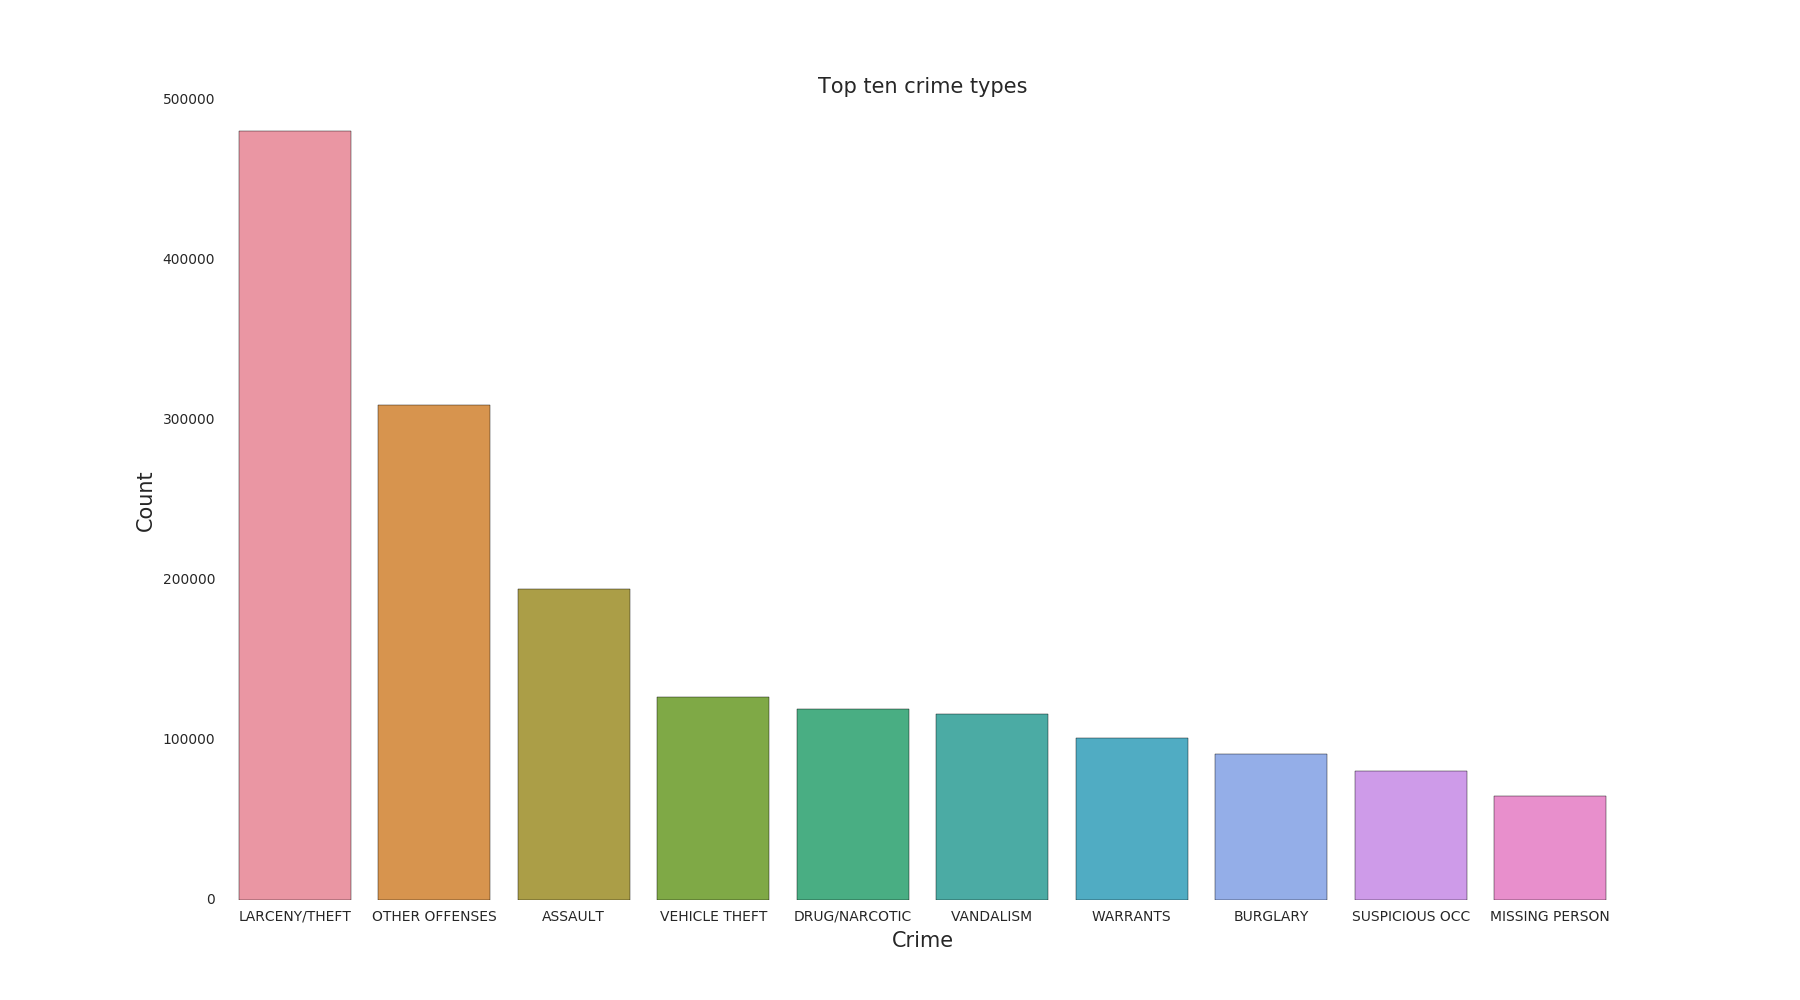

In [13]:
# Visualize top ten crimes in San Francisco
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x='category', y='count', data=q1.loc[:9, :], ax=ax)
ax.set_title('Top ten crime types', fontsize=15)
ax.set_xlabel('Crime', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
display(fig)

##### 2. Counts the number of crimes for different district.

In [15]:
q2_result = df_crime.groupBy('PdDistrict').count().orderBy('count', ascending=False)
q2_result.show()

+----------+------+
PdDistrict| count|
+----------+------+
 SOUTHERN|349942|
 MISSION|268163|
 NORTHERN|246198|
 BAYVIEW|204893|
 CENTRAL|197616|
 INGLESIDE|176543|
TENDERLOIN|172931|
 TARAVAL|148589|
 PARK|109945|
 RICHMOND|101745|
+----------+------+

In [16]:
# The number of crimes for different district
q2 = q2_result.toPandas()
print(q2)

PdDistrict count
0 SOUTHERN 349942
1 MISSION 268163
2 NORTHERN 246198
3 BAYVIEW 204893
4 CENTRAL 197616
5 INGLESIDE 176543
6 TENDERLOIN 172931
7 TARAVAL 148589
8 PARK 109945
9 RICHMOND 101745

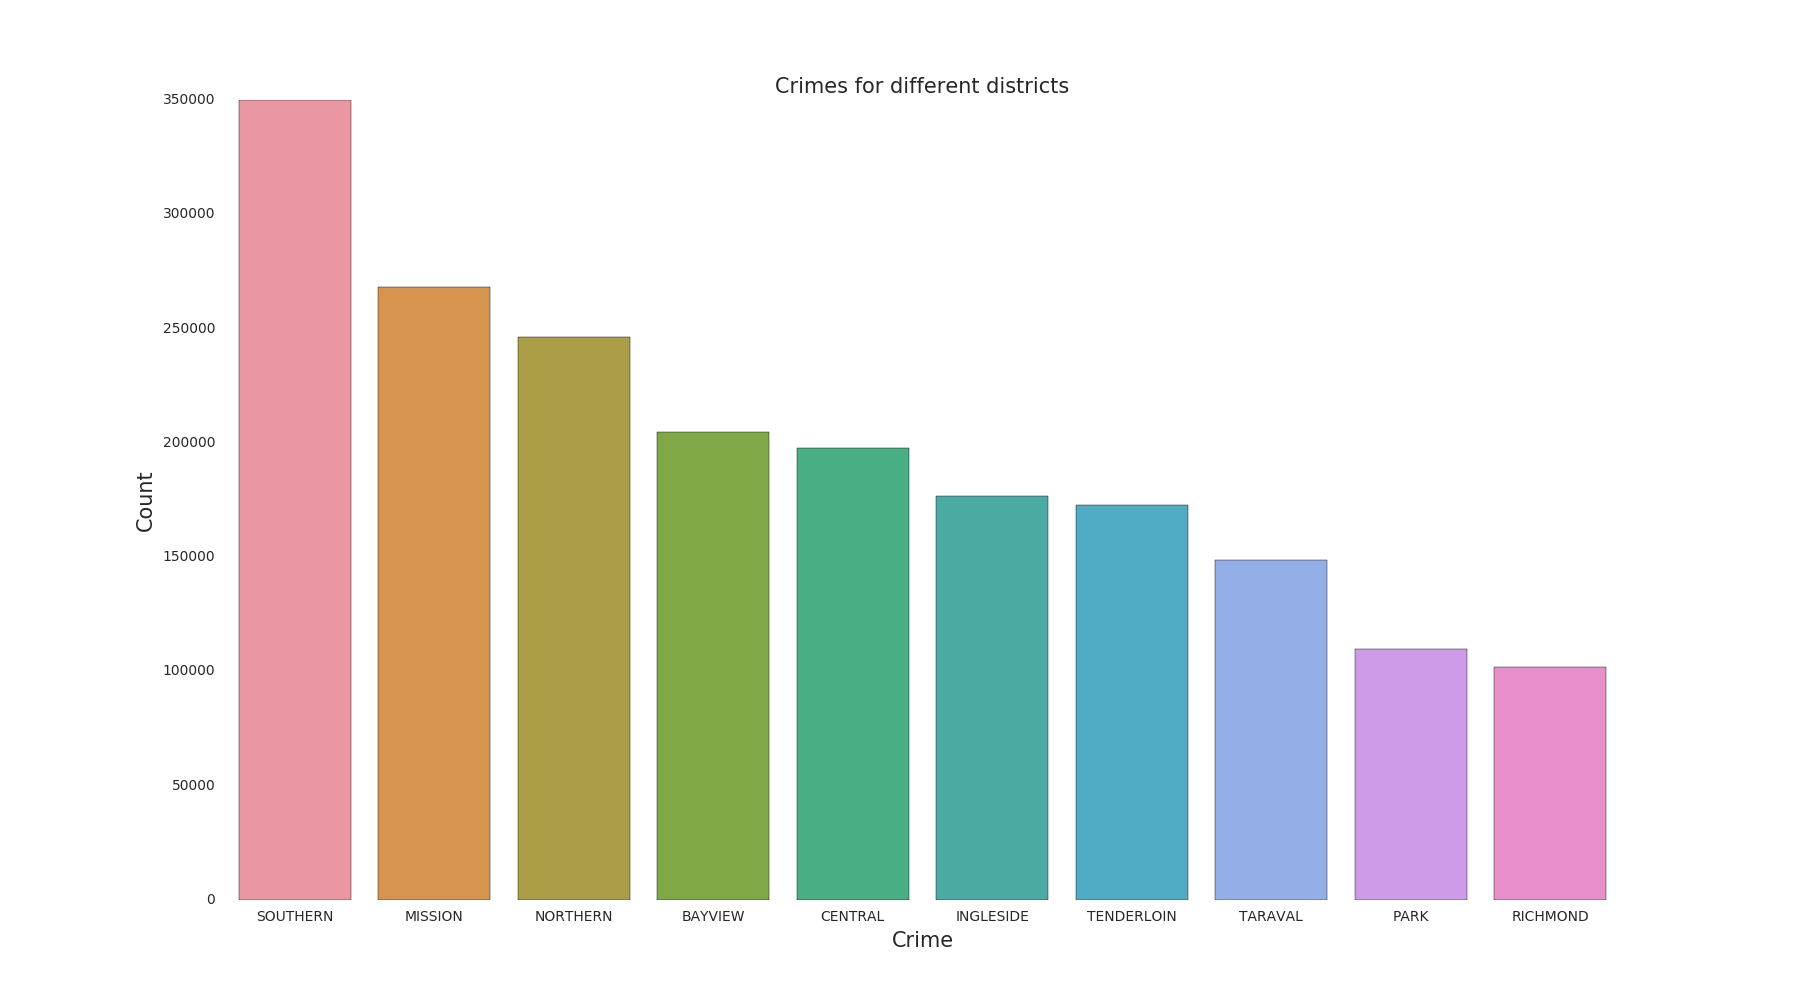

In [17]:
# Visualize crimes for different district
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x='PdDistrict', y='count', data=q2, ax=ax)
ax.set_title('Crimes for different districts', fontsize=15)
ax.set_xlabel('Crime', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
display(fig)

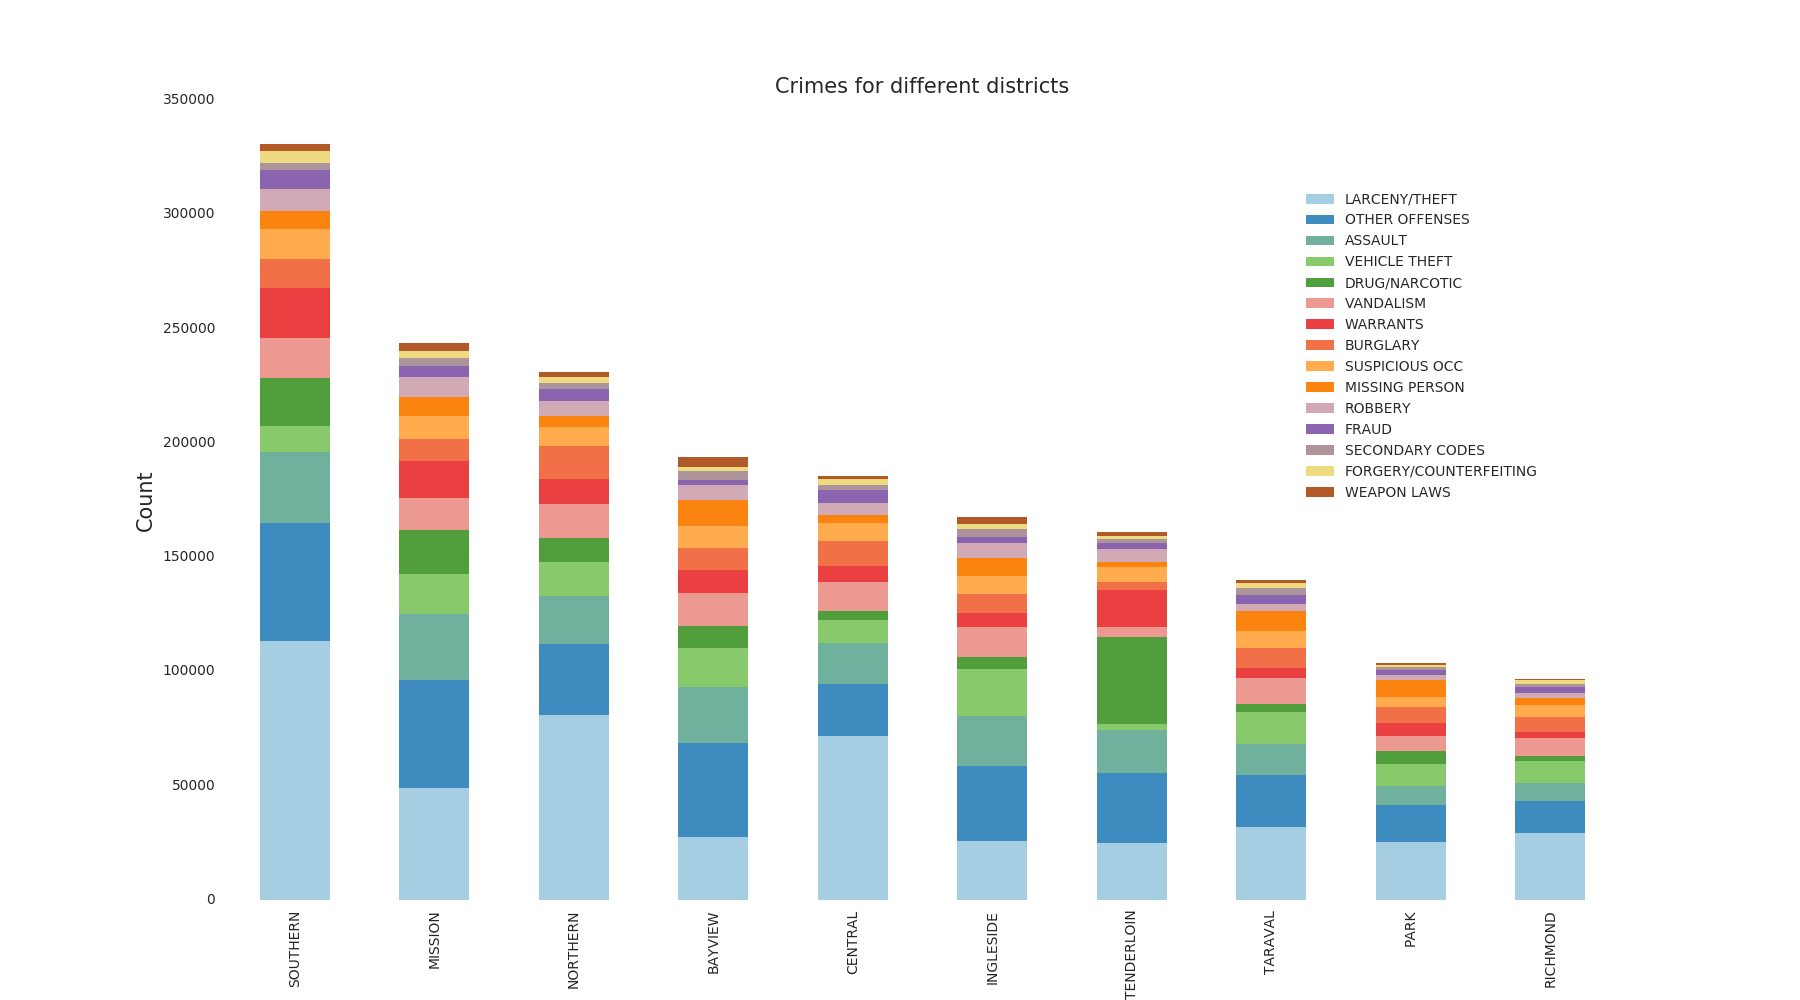

In [18]:
# Visualize crimes of different categories for different district, here we take the top 15 crime categories.
fig, ax = plt.subplots(figsize=(18, 10))
df_Pd = df_crime.groupBy('Category', 'PdDistrict').count()
q2_2 = df_Pd.toPandas()
table = pd.pivot_table(q2_2, values='count', index=['PdDistrict'], columns=['Category'])
table = table[q1['category'][:15].values]
order = q2['PdDistrict'].values
table.loc[order].plot.bar(stacked=True, ax=ax, edgecolor = "none", cmap='Paired').legend(bbox_to_anchor=(0.95, 0.9))
ax.set_title('Crimes for different districts', fontsize=15)
ax.set_xlabel('Crime', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
display(fig)

##### 3. Count the number of crimes each "Sunday" at "SF downtown".

In [20]:
def check_corrd(x, y):
  x = float(x)
  y = float(y)
  # Define SF downtown as Finantial District
  bound = [-122.406977, -122.396350, 37.793638, 37.797777]
  return x > bound[0] and x < bound[1] and y > bound[2] and y < bound[3]

In [21]:
# Filter data within SF downtown on Sundays
udf_corrd = udf(lambda x, y: check_corrd(x, y))
df_downtown = df_crime.select('Category', 'DayOfWeek', 'Date', 'Location', udf_corrd('X', 'Y').alias('Downtown'))
df_downtown = df_downtown.filter(df_downtown['DayOfWeek'] == 'Sunday').filter(df_downtown['Downtown'] == True)
df_downtown.show(10)

+--------------+---------+----------+--------------------+--------+
 Category|DayOfWeek| Date| Location|Downtown|
+--------------+---------+----------+--------------------+--------+
 ROBBERY| Sunday|02/01/2015|(37.7969028838908...| true|
 ROBBERY| Sunday|02/01/2015|(37.7969028838908...| true|
 ASSAULT| Sunday|02/01/2015|(37.7969028838908...| true|
 ASSAULT| Sunday|02/01/2015|(37.7969028838908...| true|
MISSING PERSON| Sunday|02/01/2015|(37.7951450868486...| true|
MISSING PERSON| Sunday|02/01/2015|(37.7951450868486...| true|
 LARCENY/THEFT| Sunday|02/08/2015|(37.7953124364807...| true|
 DRUG/NARCOTIC| Sunday|02/08/2015|(37.7956016951648...| true|
OTHER OFFENSES| Sunday|02/08/2015|(37.7956016951648...| true|
 TRESPASS| Sunday|02/08/2015|(37.7956016951648...| true|
+--------------+---------+----------+--------------------+--------+
only showing top 10 rows

In [22]:
# Total number of crimes by category happend on Sundays at SF downtown
q3_result = df_downtown.groupBy('category').count().orderBy('count', ascending=False)
q3_result.show(10)

+--------------+-----+
 category|count|
+--------------+-----+
 LARCENY/THEFT| 874|
 ASSAULT| 356|
OTHER OFFENSES| 293|
 VANDALISM| 246|
 BURGLARY| 162|
SUSPICIOUS OCC| 137|
 VEHICLE THEFT| 119|
 WARRANTS| 100|
 ROBBERY| 90|
 FRAUD| 58|
+--------------+-----+
only showing top 10 rows

In [23]:
# Number of crimes each Sunday at SF downtown
q3_2 = df_downtown.groupBy('Date').count()
q3_2.show(20)

+----------+-----+
 Date|count|
+----------+-----+
11/17/2013| 4|
12/13/2009| 4|
07/24/2005| 2|
06/26/2005| 2|
10/10/2004| 2|
05/31/2009| 3|
05/17/2009| 4|
11/20/2011| 2|
03/18/2007| 4|
12/19/2004| 4|
05/18/2003| 5|
08/22/2010| 4|
11/13/2011| 2|
06/14/2009| 8|
10/19/2014| 13|
07/18/2010| 4|
11/20/2005| 5|
11/10/2013| 5|
05/12/2013| 4|
10/02/2011| 4|
+----------+-----+
only showing top 20 rows

Results show that the number of crimes on Sunday at SF downtown is quite small with less than 10 incidents each day. The top three types of crimes are theft, assault, and offenses.

##### 4. The number of crime in each month of 2015, 2016, 2017, 2018.

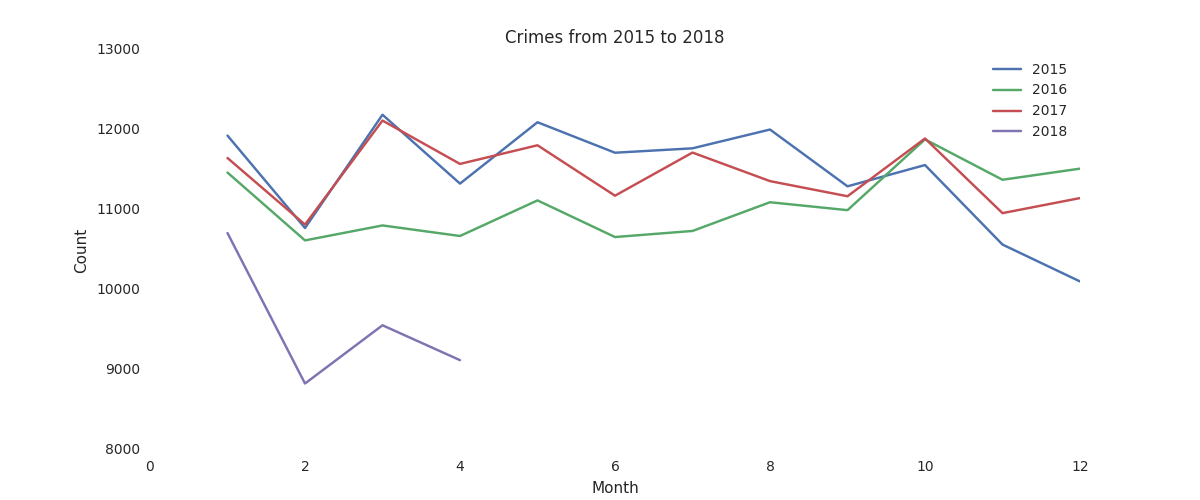

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
for year in ['2015', '2016', '2017', '2018']:
    df_month = df_crime.filter(df_crime['Year'] == year).groupBy('Month').count().orderBy('Month', ascending=True)
    df_month = df_month.toPandas()
    if year == '2018':
      df_month = df_month.loc[:3,:]
    ax.plot(df_month['Month'], df_month['count'],label = year)
    ax.set_title('Crimes from 2015 to 2018')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.set_ylim([8000, 13000])
    ax.legend()
display(fig)

The number of crimes happens each month from 2015 to 2017 is quite stable. But there is a large drop of crimes in 2018. This may be due to some policies executed since 2018 and will attract more business to open in SF.

##### 5. The number of crime w.r.t the hour in Summer and Winter holiday.

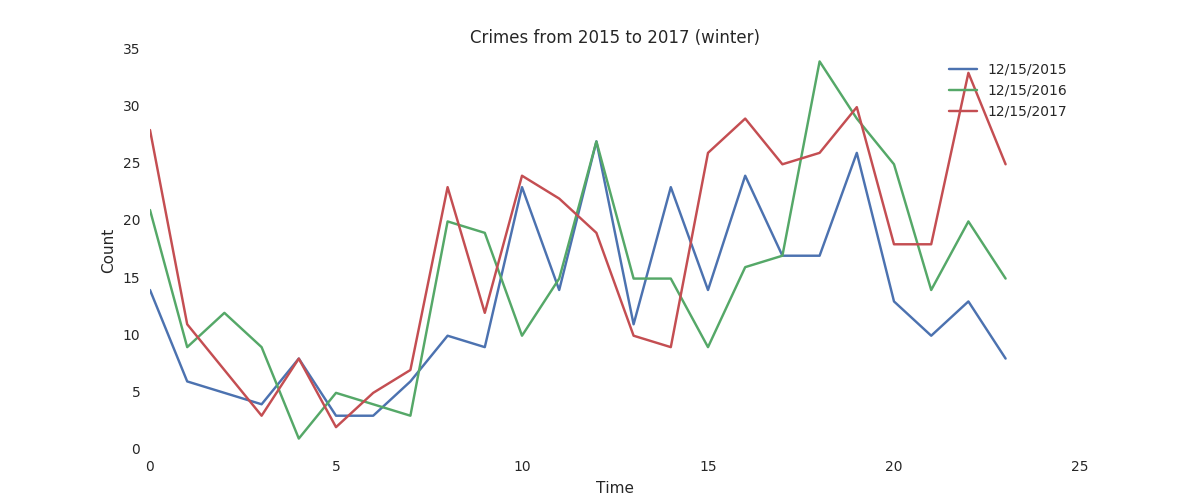

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
for date in ['12/15/2015', '12/15/2016', '12/15/2017']:
    df_hour = df_crime.filter(df_crime['Date'] == date).groupBy('Hour').count().orderBy('Hour', ascending=True)
    df_hour = df_hour.toPandas()
    ax.plot(df_hour['Hour'], df_hour['count'], label=date)
    ax.set_title('Crimes from 2015 to 2017 (winter)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Count')
    ax.legend()
display(fig)

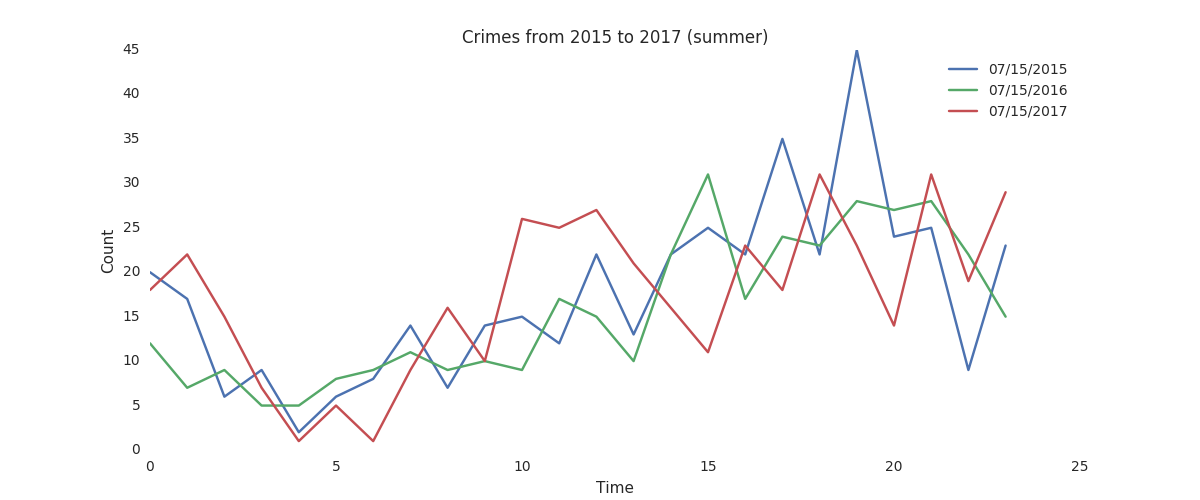

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
for date in ['07/15/2015', '07/15/2016', '07/15/2017']:
    df_hour = df_crime.filter(df_crime['Date'] == date).groupBy('Hour').count().orderBy('Hour', ascending=True)
    df_hour = df_hour.toPandas()
    ax.plot(df_hour['Hour'], df_hour['count'], label=date)
    ax.set_title('Crimes from 2015 to 2017 (summer)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Count')
    ax.legend()
display(fig)

Here we use one day in July and one day in December as example to examine the crimes in a day by hours. Overall there are more crimes in Summer than in Winter. Most crimes happened at night around 17pm to 20pm, followed by 10am to 12pm. Note that there usually a rise of crimes at midnight. Travelers to SF need to be aware of the crimes at lunch and dinner time.

##### 6. Analyze the crime event w.r.t category and time (hour) top-3 danger district.

In [33]:
# Top-3 danger district
q2.head(3)

Out[ 47 ]: 
 PdDistrict count
0 SOUTHERN 349942
1 MISSION 268163
2 NORTHERN 246198

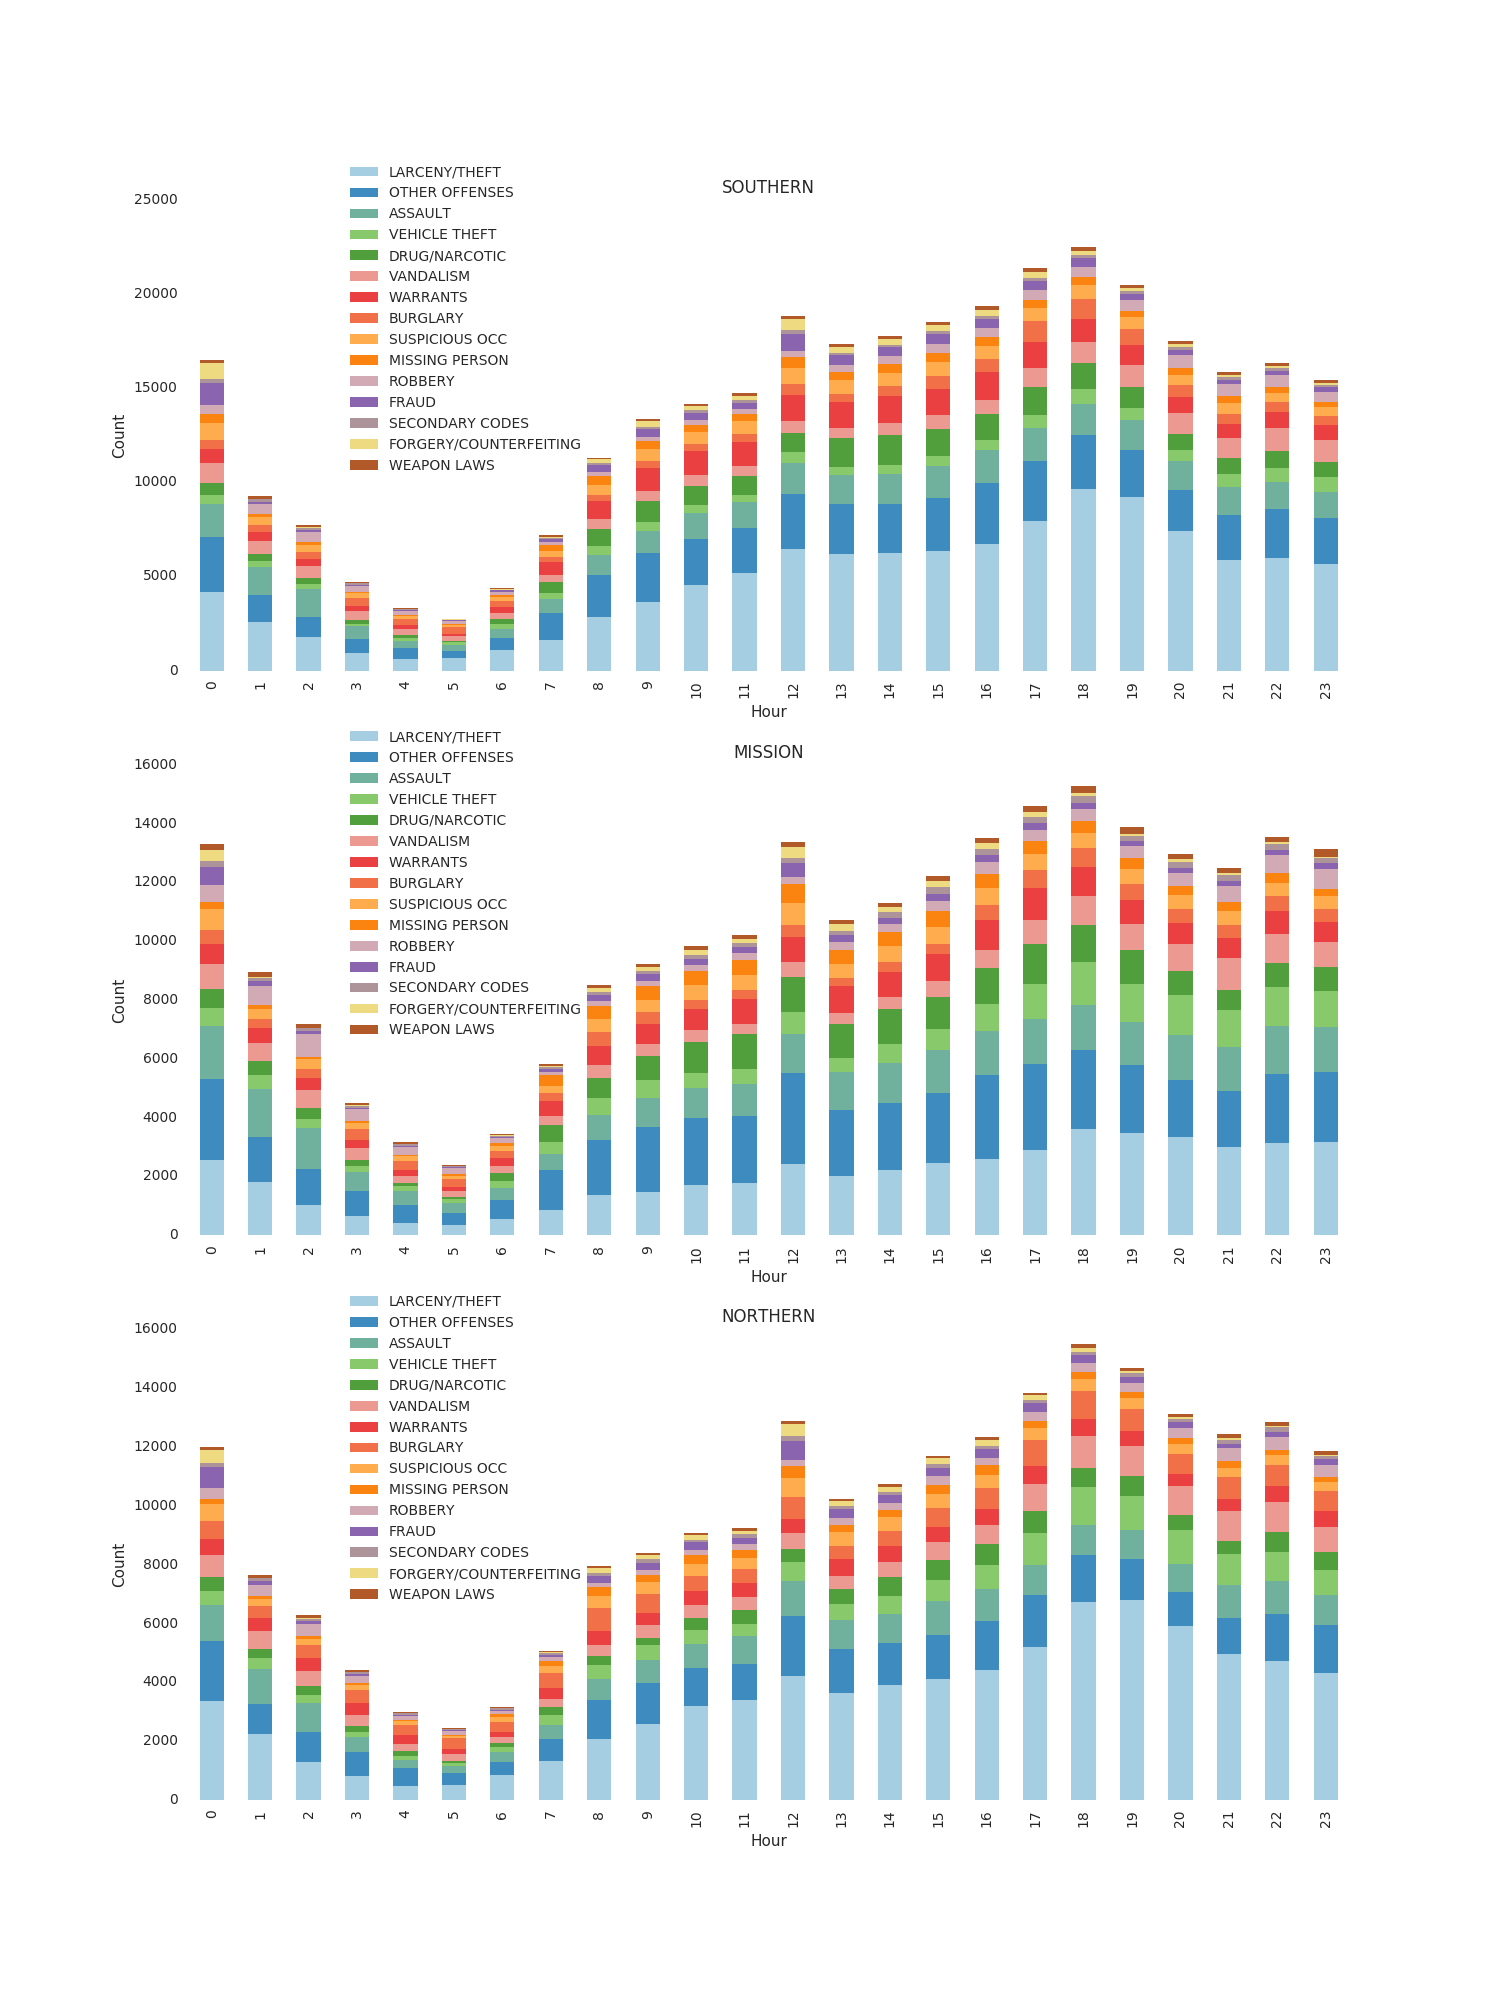

In [34]:
# Visualize crime event w.r.t category and time (hour) top-3 danger district
fig, ax = plt.subplots(3, 1, figsize=(15, 20))
area = ['SOUTHERN', 'MISSION', 'NORTHERN']
for i in range(3):
    df_area = df_crime.filter(df_crime['PdDistrict'] == area[i]).groupBy('Category', 'Hour').count()
    q6 = df_area.toPandas()
    table = pd.pivot_table(q6, values='count', index=['Hour'], columns=['Category'])
    table = table[q1['category'][:15].values]
    table.plot.bar(stacked=True, ax=ax[i], edgecolor = "none", cmap='Paired').legend(bbox_to_anchor=(0.35, 1.1))
    ax[i].set_title(area[i])
    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Count')
display(fig)

From the plot, we found that the crime rate is high around 18pm, 12pm and 12am, while the crime rate is lowest at 5am. Larceny/theft and vehicle theft usually happens at night while drug/narcotic usually happens more in the afternoon. SOUTHERN and NORTHERN districts have more larceny/theft incidents while MISSION has more offenses and viehcle theft crimes. The police department should disparse personel based on the charateristics in different districts.

##### 7. Analyze the percentage of different crime categories.

In [37]:
df_q7 = df_crime.filter(df_crime['Year'] != 2018).groupBy('Year', 'Category').count().orderBy('Category', 'Year', ascending=True)
df_q7 = df_q7.toPandas()
sum_year = df_q7.groupby('Year').sum()
df_q7 = df_q7.merge(sum_year, how='left', left_on='Year', right_index=True)
df_q7['percentage'] = df_q7['count_x'] / df_q7['count_y']
df_q7.head(10)

Out[ 49 ]: 
 Year Category count_x count_y percentage
0 2003 ARSON 293 135996 0.002154
1 2004 ARSON 280 134333 0.002084
2 2005 ARSON 231 128066 0.001804
3 2006 ARSON 240 124485 0.001928
4 2007 ARSON 246 124962 0.001969
5 2008 ARSON 248 129007 0.001922
6 2009 ARSON 222 127465 0.001742
7 2010 ARSON 209 119646 0.001747
8 2011 ARSON 203 117111 0.001733
9 2012 ARSON 237 123910 0.001913

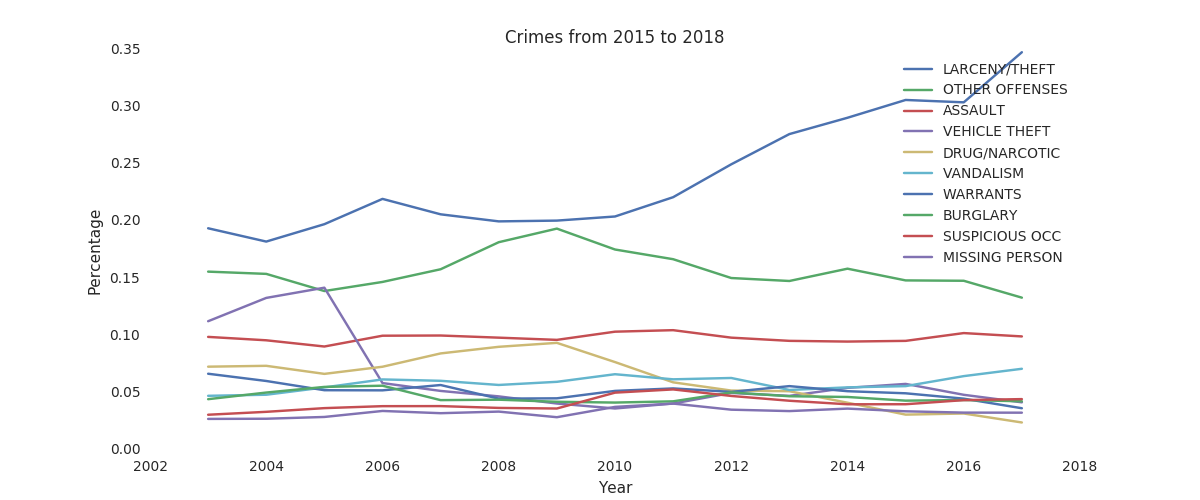

In [38]:
# Visualize the percentage of different crime categories (top ten) over time 
fig, ax = plt.subplots(figsize=(12, 5))
for category in q1['category'][:10].values:
    df_temp = df_q7[df_q7['Category'] == category]
    ax.plot(df_temp['Year'], df_temp['percentage'],label = category)
    ax.set_title('Crimes from 2015 to 2018')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage')
    ax.legend()
display(fig)

We found that larceny/theft increased around 15% since 2010. Offenses and drug/narcotic decreases since 2009. Vehicle theft has a huge decrease in 2005. The other crime types didn't change much over time. The police department needs to formulate some effective policy focused on larceny/theft.

#### Apply Spark ML clustering for spatial data analysis

In [41]:
q8_result = df_crime.groupBy('X', 'Y').count()
q8 = q8_result.toPandas()

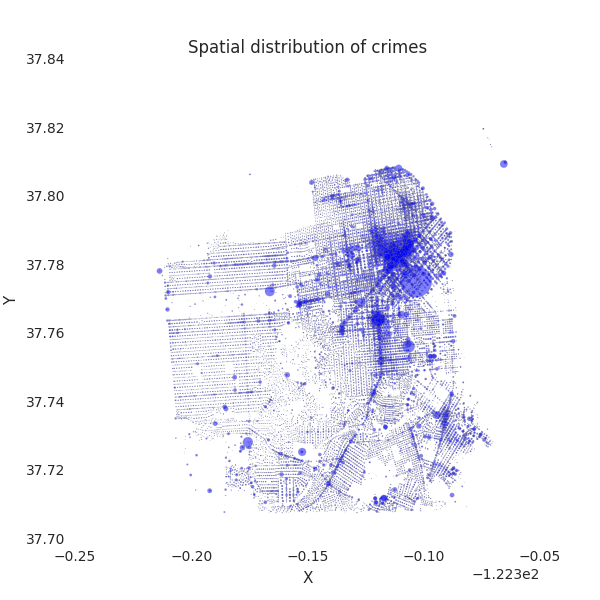

In [42]:
# Visualize the spatial distribution of crimes
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(q8['X'], q8['Y'], s=q8['count']/100, alpha=0.5, edgecolors='grey')
ax.set_title('Spatial distribution of crimes')
ax.set_xlabel('X')
ax.set_ylabel('Y')
display(fig)

The dot size imply the number of crimes in that place, we can see that the crime rate is very high in the northeast of SF where also has most population.

In [44]:
# Perfrom clustering analysis based on the number of top 5 crime categories at different location.
df_cluster = df_crime.groupBy('X', 'Y').pivot('Category').count()
df_cluster = df_cluster.na.fill(0)

In [45]:
FEATURES_COL = ['LARCENY/THEFT', 'OTHER OFFENSES', 'ASSAULT', 'VEHICLE THEFT', 'DRUG/NARCOTIC']

In [46]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df_cluster).select('X', 'Y', 'features')
df_kmeans.show(20)

+-----------+---------+--------------------+
 X| Y| features|
+-----------+---------+--------------------+
-122.467514|37.765877|[36.0,15.0,1.0,13...|
 -122.41089|37.802082| (5,[0],[2.0])|
 -122.42937| 37.76604|[5.0,4.0,2.0,0.0,...|
 -122.46055|37.781315|[38.0,12.0,34.0,1...|
 -122.41498| 37.74188|[2.0,1.0,1.0,3.0,...|
 -122.45611|37.718235|[9.0,16.0,4.0,2.0...|
-122.456406| 37.70969|[2.0,10.0,8.0,3.0...|
-122.410645|37.790627|[5.0,2.0,3.0,2.0,...|
 -122.38|37.727787|[4.0,19.0,7.0,4.0...|
-122.455795|37.774673|[19.0,9.0,3.0,11....|
-122.393074|37.756355|[17.0,10.0,9.0,14...|
 -122.40558|37.790565|[83.0,15.0,14.0,1...|
 -122.40891|37.795685| (5,[0],[4.0])|
 -122.43828|37.715034|[4.0,3.0,3.0,4.0,...|
 -122.45986|37.725056|[4.0,1.0,2.0,3.0,...|
 -122.47888|37.725845|[68.0,43.0,22.0,8...|
-122.420654|37.772095|[28.0,1.0,3.0,9.0...|
 -122.4026|37.722572|[2.0,7.0,1.0,4.0,...|
 -122.4126| 37.78112|[117.0,97.0,192.0...|
-122.410225| 37.75513|[8.0,26.0,16.0,6....|
+-----------+---------+--------------------+
only showing top 20 rows

In [47]:
# Trains a k-means model.
kmeans = KMeans().setK(5).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

In [48]:
transformed = model.transform(df_kmeans).select('X', 'Y', 'prediction')
rows = transformed.collect()
print(rows[:5])

[Row(X=-122.46751403808594, Y=37.76587677001953, prediction=0), Row(X=-122.410888671875, Y=37.80208206176758, prediction=0), Row(X=-122.42936706542969, Y=37.76604080200195, prediction=0), Row(X=-122.4605484008789, Y=37.781314849853516, prediction=0), Row(X=-122.41497802734375, Y=37.741878509521484, prediction=0)]

In [49]:
# Clustering result
df_pred = sqlContext.createDataFrame(rows)
df_pred.show(20)

+-------------------+------------------+----------+
 X| Y|prediction|
+-------------------+------------------+----------+
-122.46751403808594| 37.76587677001953| 0|
 -122.410888671875| 37.80208206176758| 0|
-122.42936706542969| 37.76604080200195| 0|
 -122.4605484008789|37.781314849853516| 0|
-122.41497802734375|37.741878509521484| 0|
-122.45610809326172| 37.71823501586914| 0|
-122.45640563964844| 37.70969009399414| 0|
 -122.41064453125|37.790626525878906| 0|
-122.37999725341797|37.727787017822266| 0|
-122.45579528808594| 37.77467346191406| 0|
-122.39307403564453| 37.75635528564453| 0|
-122.40557861328125|37.790565490722656| 0|
 -122.4089126586914|37.795684814453125| 0|
-122.43827819824219| 37.71503448486328| 0|
 -122.4598617553711| 37.72505569458008| 0|
 -122.4788818359375| 37.72584533691406| 0|
 -122.420654296875| 37.7720947265625| 0|
-122.40260314941406|37.722572326660156| 0|
 -122.41259765625| 37.78112030029297| 4|
-122.41022491455078|37.755130767822266| 0|
+-------------------+------------------+----------+
only showing top 20 rows

In [50]:
# Merge clustering results with crime counts
df_pred = df_pred.toPandas()
df_pred = df_pred.merge(q8, on=['X','Y'])
df_pred.head(20)

Out[ 59 ]: 
 X Y prediction count
0 -122.467514 37.765877 0 81
1 -122.410889 37.802082 0 5
2 -122.429367 37.766041 0 20
3 -122.460548 37.781315 0 160
4 -122.414978 37.741879 0 84
5 -122.456108 37.718235 0 52
6 -122.456406 37.709690 0 53
7 -122.410645 37.790627 0 27
8 -122.379997 37.727787 0 80
9 -122.455795 37.774673 0 66
10 -122.393074 37.756355 0 83
11 -122.405579 37.790565 0 181
12 -122.408913 37.795685 0 12
13 -122.438278 37.715034 0 28
14 -122.459862 37.725056 0 15
15 -122.478882 37.725845 0 350
16 -122.420654 37.772095 0 64
17 -122.402603 37.722572 0 24
18 -122.412598 37.781120 4 807
19 -122.410225 37.755131 0 115

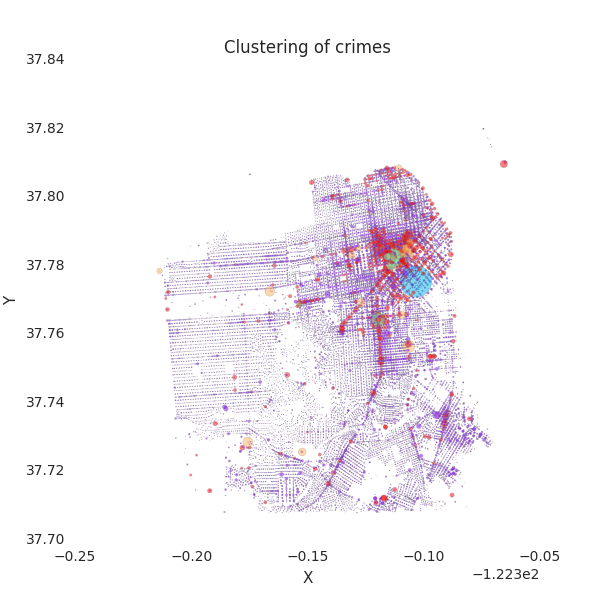

In [51]:
# Visulize clustering results (5 clusters)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_pred['X'], df_pred['Y'], s=df_pred['count']/100, c=df_pred['prediction'], cmap='rainbow', alpha=0.5, edgecolors='grey')
ax.set_title('Clustering of crimes')
ax.set_xlabel('X')
ax.set_ylabel('Y')
display(fig)

#### Time series analysis 
1.visualize time series  
2.plot ACF and find optimal parameter  
3.Train ARIMA  
4.Prediction

In [53]:
df_ts = df_crime.groupBy('Date', 'Category').count().orderBy('Date', ascending=True)
df_ts = df_ts.toPandas()

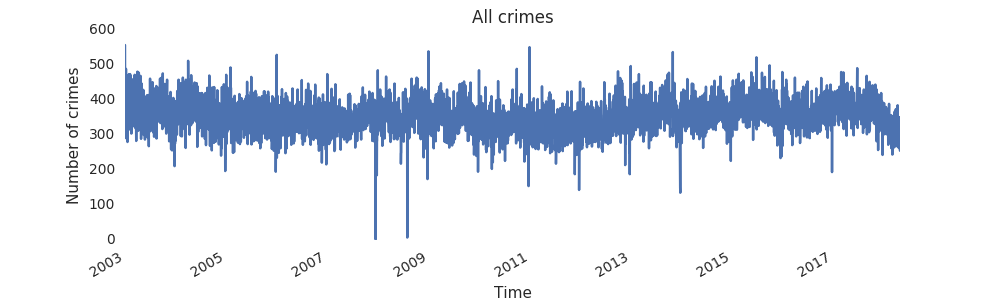

In [54]:
# Visualize time series of all crimes
df_all = df_ts.groupby('Date').sum()
df_all.index = pd.to_datetime(df_all.index)
df_all = df_all['2003-1' : '2018-4']
fig, ax = plt.subplots(figsize=(10, 3))
df_all['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of crimes')
ax.set_title('All crimes')
display(fig)

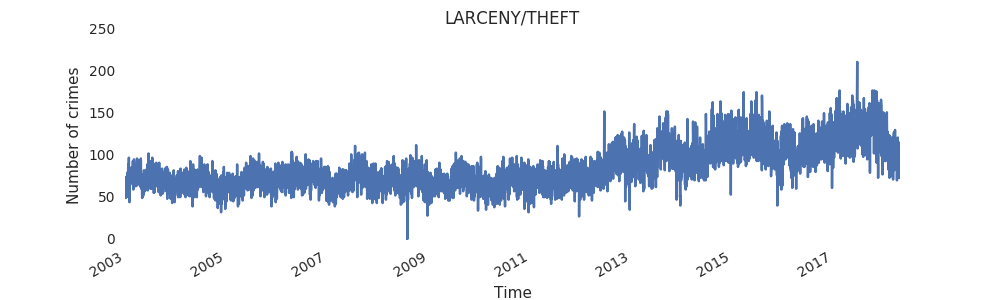

In [55]:
# Visualize time series of LARCENY/THEFT
df_LARCENY = df_ts[df_ts['Category'] == 'LARCENY/THEFT']
df_LARCENY.index = pd.to_datetime(df_LARCENY.Date)
df_LARCENY = df_LARCENY['2003-1' : '2018-4']
fig, ax = plt.subplots(figsize=(10, 3))
df_LARCENY['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of crimes')
ax.set_title('LARCENY/THEFT')
display(fig)

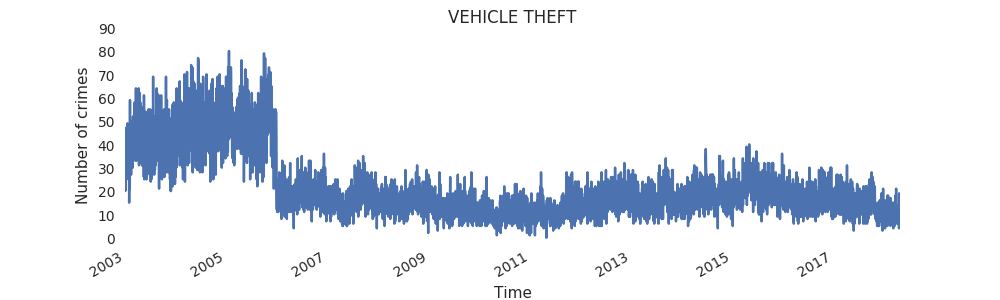

In [56]:
# Visualize time series of VEHICLE THEFT
df_VEHICLE = df_ts[df_ts['Category'] == 'VEHICLE THEFT']
df_VEHICLE.index = pd.to_datetime(df_VEHICLE.Date)
df_VEHICLE = df_VEHICLE['2003-1' : '2018-4']
fig, ax = plt.subplots(figsize=(10, 3))
df_VEHICLE['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of crimes')
ax.set_title('VEHICLE THEFT')
display(fig)

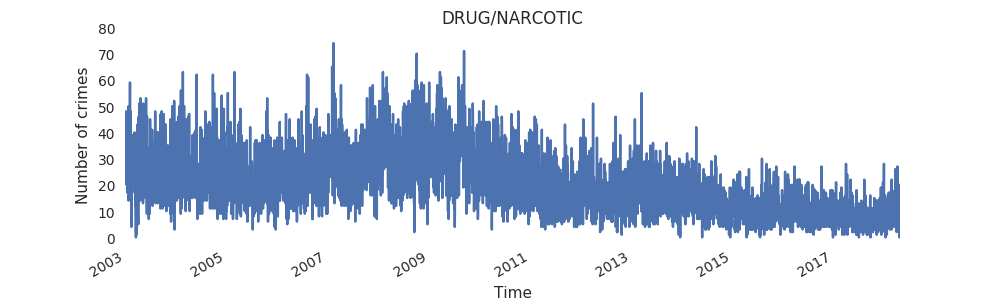

In [57]:
# Visualize time series of DRUG/NARCOTIC
df_DRUG = df_ts[df_ts['Category'] == 'DRUG/NARCOTIC']
df_DRUG.index = pd.to_datetime(df_DRUG.Date)
df_DRUG = df_DRUG['2003-1' : '2018-4']
fig, ax = plt.subplots(figsize=(10, 3))
df_DRUG['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of crimes')
ax.set_title('DRUG/NARCOTIC')
display(fig)

Overall crime rate do not change much over the years with a slghtly of decreases since 2018. LARCENY/THEFT rate increased since 2013, VEHICLE THEFT rate had a huge drop around 2006, DRUG/NARCOTIC rate decrease gradually since 2013.

##### Build ARIMA to predict LARCENY/THEFT crime.

In [60]:
# Groups the data in buckets by start of the month
df_month = df_LARCENY.resample('MS').sum()

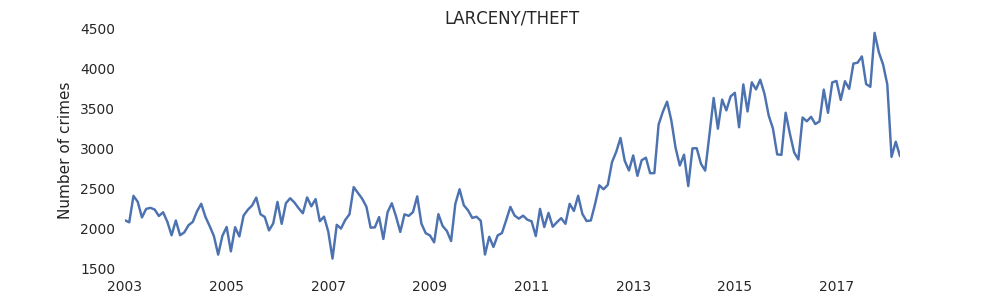

In [61]:
fig, ax = plt.subplots(figsize=(10, 3))
df_month['count'].plot()
plt.xlabel('Time')
plt.ylabel('Number of crimes')
ax.set_title('LARCENY/THEFT')
display(fig)

Intuitively, the data is not stationary. We will analyze further.

In [63]:
#  Run augmented Dickey-Fuller test to check the stationarity
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
testStationarity(df_month['count'])

Out[ 68 ]: 
Test Statistic -1.033483
p-value 0.740857
#Lags Used 12.000000
Number of Observations Used 171.000000
Critical Value (5%) -2.878595
Critical Value (10%) -2.575863
Critical Value (1%) -3.469181
dtype: float64

p-value larger than 0.05. Can't reject the hypothesis. The time series is not stationary.

##### Plot ACF and PACF

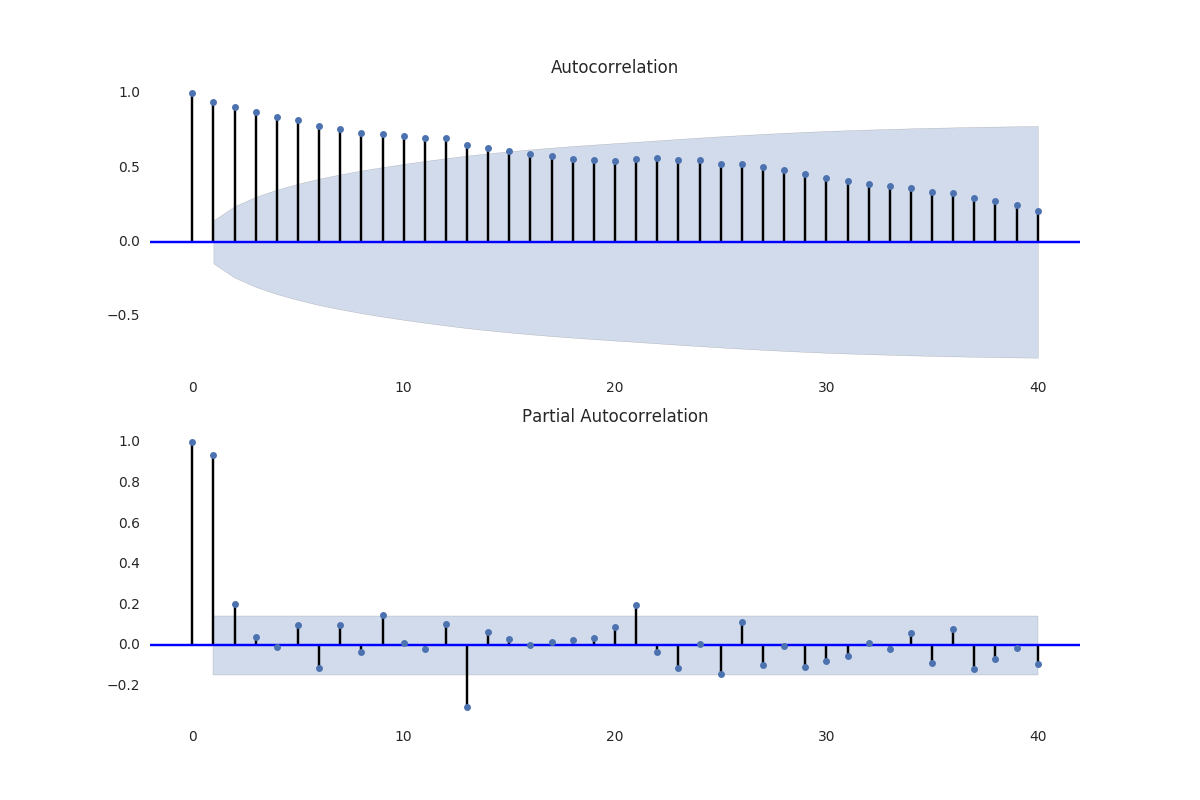

In [66]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_month['count'].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_month['count'], lags=40, ax=ax2)
display(fig)

##### Time series decomposition

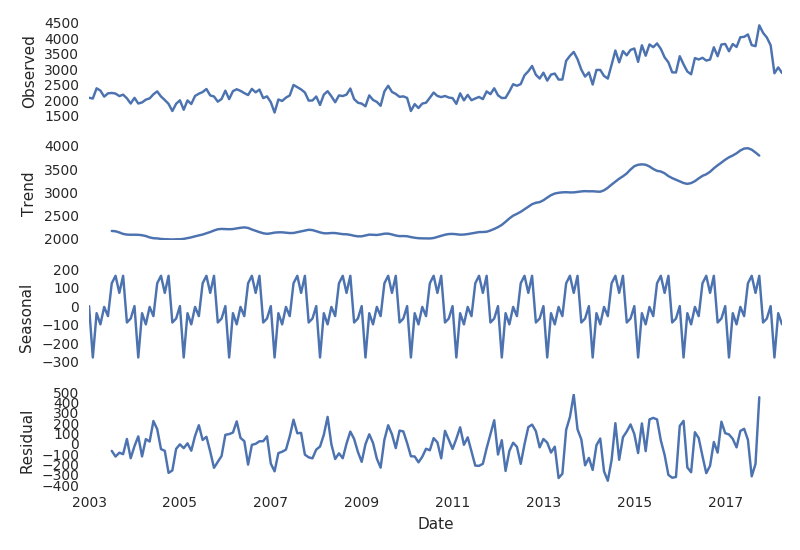

In [68]:
fig = plt.figure(figsize=(20,20))  
decomposition = seasonal_decompose(df_month, freq=12)  
fig = decomposition.plot()  
display(plt.show())

From the ACF and PCF plot, and the seasonality after decomposition, we further confirmed that the time series is not stationary and there is also a 12 month seasonal period in the time series. We will use a seasonal ARIMA model for prediction.

We will use grid search to find the best hyper parameter for the model, below we iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model.

##### Seasonal ARIMA model

In [71]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [72]:
warnings.filterwarnings("ignore")
# split train and test data
train, test = df_month[:-12], df_month[-12:]
res = float('inf')
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if res > results.aic:
              best_param = param + param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2783.136715677601
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2165.16536800804
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2343.799996627261
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2306.9436993548243
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2174.5805413359503
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2158.884125270486
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2948.282228668033
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2603.3372927620235
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2236.38635372737
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2061.946558560176
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2259.9060321276265
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2198.024985469972
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2081.798209475284
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2054.3925377088017
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2140.3896837901725
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1944.8051992764854
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2143.676565209659
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2107.9890716967147
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1996.8571790828119
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1946.8036149459085
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:2286.0173981558914
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2120.2747271441
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:2163.366865775397
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1931.4245140384683
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:2138.5867506731283
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2091.9946251178153
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1996.43386661076
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1933.421795850842
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:2328.9309894085686
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2156.2280785846074
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:2179.8267567291186
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1959.0068398243282
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:2145.641567241351
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2119.066027710827
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1987.8264982106214
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1960.9965632964384
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:2302.49611845694
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2134.842221255322
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:2168.5608829338835
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1945.8724170386156
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2140.363064672242
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2107.4623212897563
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1989.7698035075714
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1947.8323321840958
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:2302.6246050270493
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2133.2557710076817
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2178.4307483869156
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1945.5726640386606
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:2126.1881535892144
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2108.8829127706085
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1983.780193021322
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1947.5706258069356
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:2285.9638278650887
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2120.349142995443
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:2154.8656521610474
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1934.3664363010084
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:2124.4018557017575
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2091.06200462998
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1973.812767816985
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1930.5704988410068

In [73]:
# Best parameter p,d,q,P,D,Q,S that have smallest AIC
print (best_param)

(1, 1, 1, 1, 1, 1, 12)

In [74]:
# Train the model
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
ar.L1 0.6560 0.150 4.366 0.000 0.361 0.950
ma.L1 -0.8437 0.109 -7.732 0.000 -1.058 -0.630
ar.S.L12 -0.0425 0.093 -0.458 0.647 -0.224 0.139
ma.S.L12 -0.9805 0.532 -1.844 0.065 -2.022 0.061
sigma2 2.859e+04 1.32e+04 2.163 0.031 2680.011 5.45e+04
==============================================================================

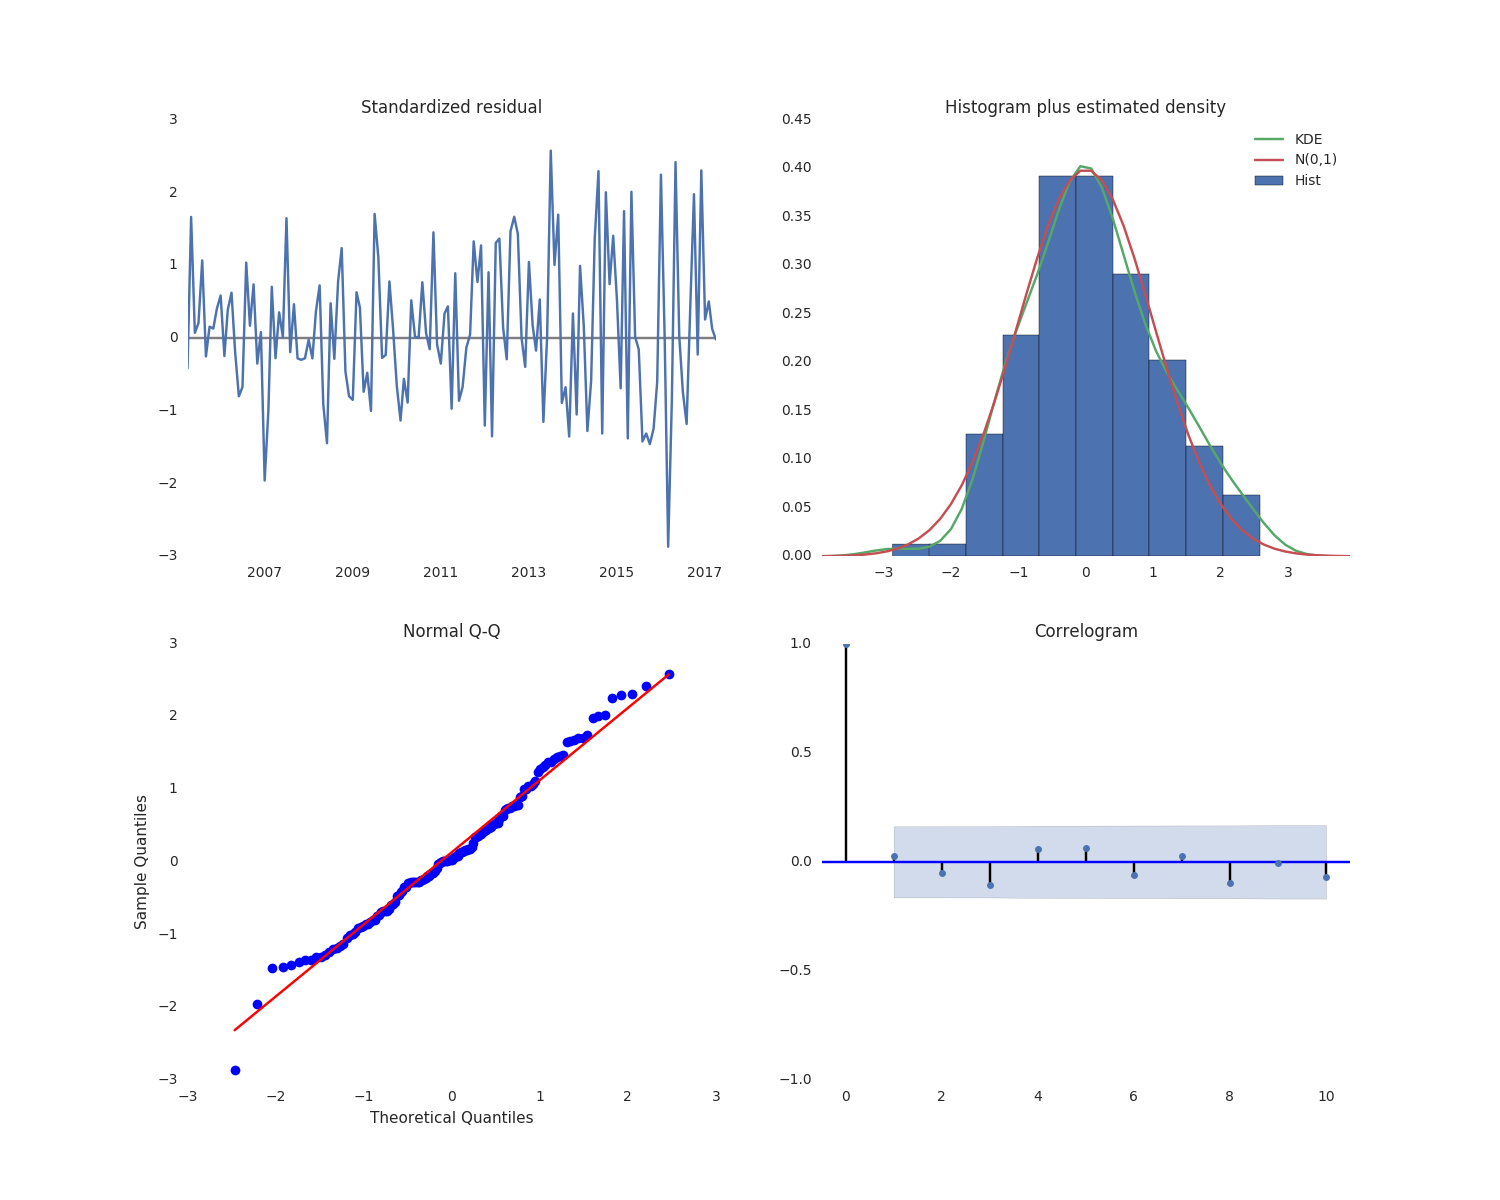

In [75]:
# Check the prediction results using diagnostic plots for standardized residuals
results.plot_diagnostics(figsize=(15, 12))
display(plt.show())

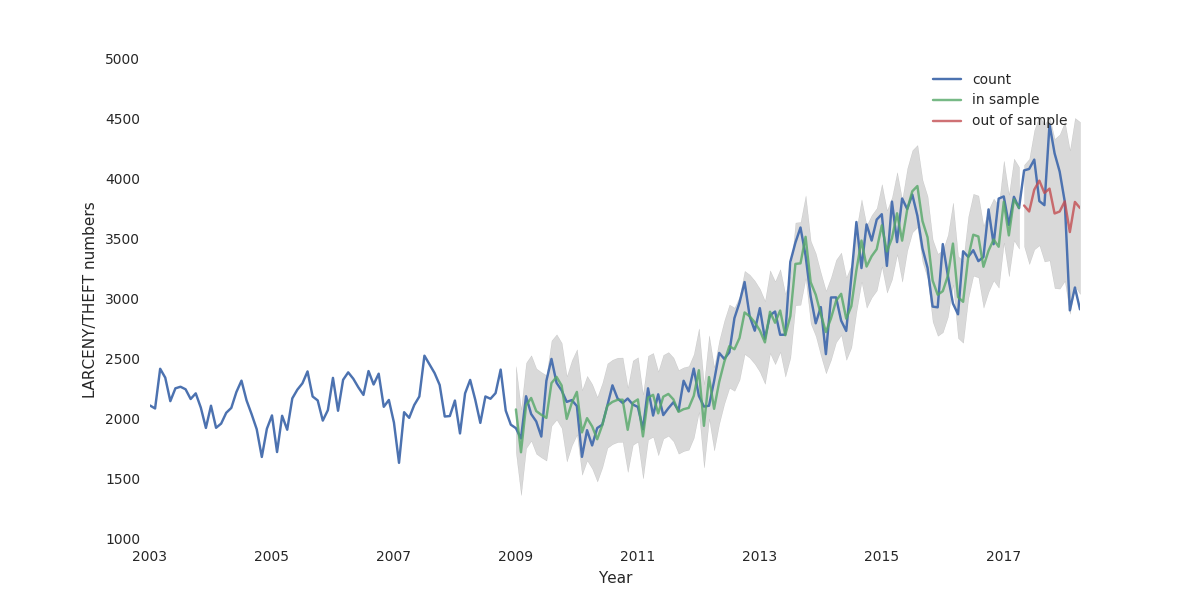

In [76]:
# Visualize the prediction
pred = results.get_prediction(start=pd.to_datetime('2009-01-01'), dynamic=False)
pred_ci = pred.conf_int()
fore = results.get_forecast(steps=12)
fore_ci = fore.conf_int() 

fig, ax = plt.subplots(figsize=(12, 6))
df_month.plot(ax=ax)
pred.predicted_mean.plot(ax=ax, label='in sample', alpha=0.8)
fore.predicted_mean.plot(ax=ax, label='out of sample', alpha=0.8)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.15)
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=0.15)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('LARCENY/THEFT numbers')
display(plt.show())

#### Conclusion. 
- Performed spatial and temporal analysis using over 2 million crime activity data of 15 years from SFPD.
- Managed dynamic data pipeline jobs using Apache Spark Dataframe and Spark SQL for data processing and feature engineering.
- Employed spatial clustering using Spark Mllib and optimized a seasonal ARIMA model for prediction of crime incidents.
- The study examined crime activity spatial distribution and variation over time by category in SF and can facilitate police department on staffing and policymaking.